#**CovidNet**

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import  accuracy_score, classification_report, confusion_matrix

from dataloader import *
from covidnet import covidnet
from train import *

we prepared a sharelink from google dive:

https://drive.google.com/drive/folders/1aw7nqrXkBRZp94Ef04s3xeH-2gQRPb97?usp=sharing

Add a shortcut to your own google drive and mount drive on google colab.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##load data & model

In [3]:
#DIRECTORIES
path_metadata = "/content/drive/MyDrive/dataset/metadata.csv" ## directory of dataframe of image directories and classes
path_pneumonia = "/content/drive/MyDrive/dataset/Dataset/pneumonia" ## directory of images of pneumonia classes
directory_dataset='/content/drive/MyDrive/dataset/Dataset' ## directory of all classes folders

image_size=(224, 224)
batch_size = 32

## call a function to load datasets
train_dataset,validation_dataset,test_dataset, y_true,y_true_oh,train_steps,validation_steps,test_steps,_,_,_ = data_func(
    batch_size ,
    path_metadata ,
    path_pneumonia ,
    directory_dataset,
    image_size )

Found 2928 validated image filenames belonging to 3 classes.
Found 732 validated image filenames belonging to 3 classes.
Found 915 validated image filenames belonging to 3 classes.
Found 50 validated image filenames belonging to 3 classes.


In [4]:
input_shape = 224, 224, 3 # size and channel of images
n_classes = 3 # number of classes

# call the model
model = covidnet(input_shape,n_classes)

##train

In [5]:
checkpoint_filepath =  '/content/covid'
opt = Adam(learning_rate = 0.0002)

from time import time
start = time()

with tf.device('/gpu:0'):
  history_covidnet,model2 = train(train_dataset, model,'covidnet',
           train_steps,
           validation_dataset,
           validation_steps,
           checkpoint_filepath,
           epoch=150,
           opt = opt)

print('Total run time = {:.2f} min'.format((time()-start)/60))

Epoch 1/150
91/91 [==============================] - 1680s 18s/step - loss: 0.9495 - accuracy: 0.5124 - val_loss: 0.7252 - val_accuracy: 0.6577 - lr: 2.0000e-04
Epoch 2/150
91/91 [==============================] - 83s 908ms/step - loss: 0.7874 - accuracy: 0.6564 - val_loss: 0.6514 - val_accuracy: 0.7656 - lr: 2.0000e-04
Epoch 3/150
91/91 [==============================] - 82s 906ms/step - loss: 0.6956 - accuracy: 0.7048 - val_loss: 0.5879 - val_accuracy: 0.7884 - lr: 2.0000e-04
Epoch 4/150
91/91 [==============================] - 82s 903ms/step - loss: 0.6222 - accuracy: 0.7459 - val_loss: 0.5188 - val_accuracy: 0.8097 - lr: 2.0000e-04
Epoch 5/150
91/91 [==============================] - 81s 894ms/step - loss: 0.5827 - accuracy: 0.7655 - val_loss: 0.6119 - val_accuracy: 0.7216 - lr: 2.0000e-04
Epoch 6/150
91/91 [==============================] - 81s 887ms/step - loss: 0.5714 - accuracy: 0.7728 - val_loss: 0.6467 - val_accuracy: 0.7145 - lr: 2.0000e-04
Epoch 7/150
91/91 [===============

### model summary

In [6]:
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 48  7104        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 56, 56, 48)   0           ['conv2d[0][0]']                 
                                                                                              

## test evaluation

In [7]:
#evaluation with last epoch weights
loss, accuracy = model2.evaluate(test_dataset)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

915/915 [==============================] - 368s 402ms/step - loss: 0.2883 - accuracy: 0.8918
Loss:  0.2883496582508087
Accuracy:  0.8918032646179199


In [8]:
# loading the weights with the best accuracy of validation dataset
model2.load_weights(checkpoint_filepath)

In [9]:
loss, accuracy = model2.evaluate(test_dataset)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

915/915 [==============================] - 15s 16ms/step - loss: 0.1932 - accuracy: 0.9410
Loss:  0.1932021677494049
Accuracy:  0.9409835934638977


In [10]:
with tf.device('/gpu:0'):
  test_values = model2.predict(test_dataset, steps=test_steps)

915/915 [==============================] - 15s 16ms/step


In [11]:
#save the prediction of the model on the test dataset to use in ensemble model
np.save("test_p_covid", test_values)

### precision, recall, fscore

In [12]:
# preparing test result

test_value_max = np.argmax(test_values,axis=1)
test_value_max_oh = convert_to_one_hot(test_value_max,3).T

In [13]:
accuracy = accuracy_score(y_true_oh, test_value_max_oh)

print('Accuracy = {:.2f}%'.format(accuracy*100))
print(classification_report(y_true_oh, test_value_max_oh,target_names=['0','1','2']))

Accuracy = 94.10%
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       280
           1       0.96      0.97      0.96       320
           2       0.99      0.90      0.94       315

   micro avg       0.94      0.94      0.94       915
   macro avg       0.94      0.94      0.94       915
weighted avg       0.94      0.94      0.94       915
 samples avg       0.94      0.94      0.94       915



###confusion matrix

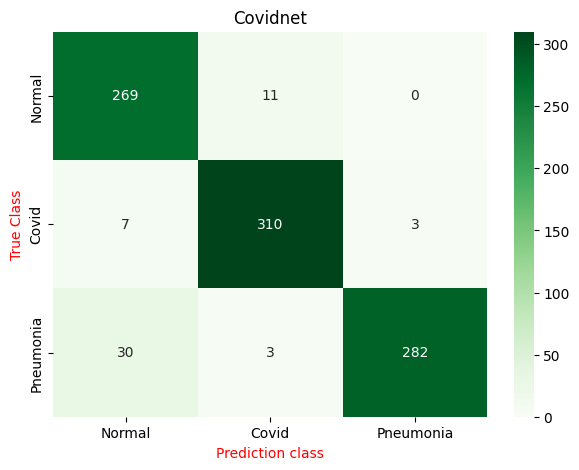

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

cf_matrix = confusion_matrix(y_true,test_value_max)

plt.figure(figsize = (7,5))
plt.title('Covidnet')
x_axis_labels = ['Normal','Covid','Pneumonia']
sns.heatmap(cf_matrix, annot=True,  fmt='g', cmap="Greens", xticklabels=x_axis_labels, yticklabels=x_axis_labels)
plt.xlabel('Prediction class', color = 'r')
plt.ylabel(ylabel='True Class', color="r")
plt.savefig('h_covid.png')